<a href="https://colab.research.google.com/github/4-OurFuture/korea_2025_nlp/blob/main/nlp_mid_term.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (개요) 주식 추천 파이프라인 시나리오
1단계: 네이버 금융에서 종목별 일별 시세 크롤링 및 통계 요약

2단계 : 네이버 뉴스 헤드라인 크롤링 및 중복 제거, 감성 분류

3단계 : Fear & Greed 지수 크롤링

4단계 : 수집된 데이터 기반 GPT API 호출로 시장 상황 요약 및 종목 추천

5단계 : Slack으로 추천 결과 전송


#(준비) 환경설정 단계

In [1]:
from google.colab import drive
# Google Drive 마운트: 인증 후 Drive를 /content/drive에 연결
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install --quiet python-dotenv transformers slack-sdk beautifulsoup4 lxml matplotlib yfinance feedparser


In [3]:
## 0. 라이브러리 및 환경 설정
import os
import datetime
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import feedparser
from bs4 import BeautifulSoup
from dotenv import load_dotenv
from transformers import pipeline
import openai
from slack_sdk import WebClient

In [4]:
# 환경 변수(.env) 로드
env_path = '/content/drive/MyDrive/ssl_cert/.env'
load_dotenv(env_path)
# 파일 존재 여부 확인
def check_env(path):
    if os.path.exists(path):
        print(".env 파일이 존재합니다.")
    else:
        print(".env 파일을 찾을 수 없습니다. 경로를 확인하세요.")

check_env(env_path)


.env 파일이 존재합니다.


In [5]:
NAVER_FINANCE_BASE = "https://finance.naver.com/item/sise_day.nhn"
NAVER_NEWS_SEARCH = "https://search.naver.com/search.naver"
INVEST_GREED_URL = "https://www.invest.com/indices/fear-and-greed-index"
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
SLACK_BOT_TOKEN = os.getenv("SLACK_BOT_TOKEN")
SLACK_CHANNEL = os.getenv("SLACK_CHANNEL")

In [6]:
# ---------------------------------------------------
# .env 파일에 키를 가지고 있지 않은 경우 이 코드를 주석 해제 후 실행 후 입력
# ---------------------------------------------------
# print('Loading API keys...')
# openai_api_key = input("Enter your OpenAI API key: ")
# slack_token = input("Enter your Slack Bot token: ")
# slack_channel = input("Enter your Slack channel id: ")

# os.environ['OPENAI_API_KEY'] = openai_api_key
# os.environ['SLACK_BOT_TOKEN'] = slack_token
# os.environ['SLACK_CHANNEL'] = slack_channel
# openai.api_key = openai_api_key
# print('API keys loaded successfully')

In [7]:
# OpenAI 및 Slack 클라이언트 설정
openai.api_key = OPENAI_API_KEY
slack_client = WebClient(token=SLACK_BOT_TOKEN)

# 1단계: 네이버 금융에서 종목별 일별 시세 크롤링 및 통계 요약

In [8]:
def get_domestic_sector_tickers():
    return {
        'IT': ['005930','000660','035720','035420'],
        'Healthcare': ['005380','207940','069620','051910'],
        'Financials': ['000810','055550','105560','105630'],
        'Energy': ['005490','006400','034020','010130'],
        'Consumer': ['051900','066570','005935','003550'],
        'Robotics': ['108380','090710','086460','095660']
    }

def get_us_sector_tickers():
    return {
        'Technology': ['AAPL','MSFT','GOOGL','INTC'],
        'Healthcare': ['JNJ','PFE','MRK','UNH'],
        'Financials': ['JPM','BAC','WFC','C'],
        'Energy': ['XOM','CVX','COP','SLB'],
        'Consumer': ['AMZN','TSLA','KO','PG'],
        'ETFs': ['SPY','QQQ','DIA','VYM', 'SCHD', 'DVY', 'SDY', 'NOBL']
    }

domestic_sectors = get_domestic_sector_tickers()
us_sectors = get_us_sector_tickers()

In [9]:
# 국내 데이터: 네이버 금융 크롤링
def fetch_domestic_stock(code, pages=5):
    url = 'https://finance.naver.com/item/sise_day.nhn'
    dfs = []
    for p in range(1, pages+1):
        r = requests.get(url, params={'code':code,'page':p}, headers={'User-Agent':'Mozilla/5.0'})
        soup = BeautifulSoup(r.text, 'lxml')
        tbl = soup.find('table', class_='type2')
        df = pd.read_html(io.StringIO(str(tbl)), header=0)[0].dropna()
        dfs.append(df)
    df = pd.concat(dfs)
    df['날짜'] = pd.to_datetime(df['날짜'], format='%Y.%m.%d')
    df.set_index('날짜', inplace=True)
    for col in ['종가','시가','고가','저가','거래량']:
        df[col] = df[col].astype(str).str.replace(',','').astype(float)
    return df

# 미국 데이터: yfinance 사용
def fetch_us_stock(ticker, period='6mo', interval='1d'):
    df = yf.download(ticker, period=period, interval=interval, progress=False)
    df.rename(columns={'Close':'종가','Open':'시가','High':'고가','Low':'저가','Volume':'거래량'}, inplace=True)
    return df[['종가','시가','고가','저가','거래량']]

YF.download() has changed argument auto_adjust default to True


/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


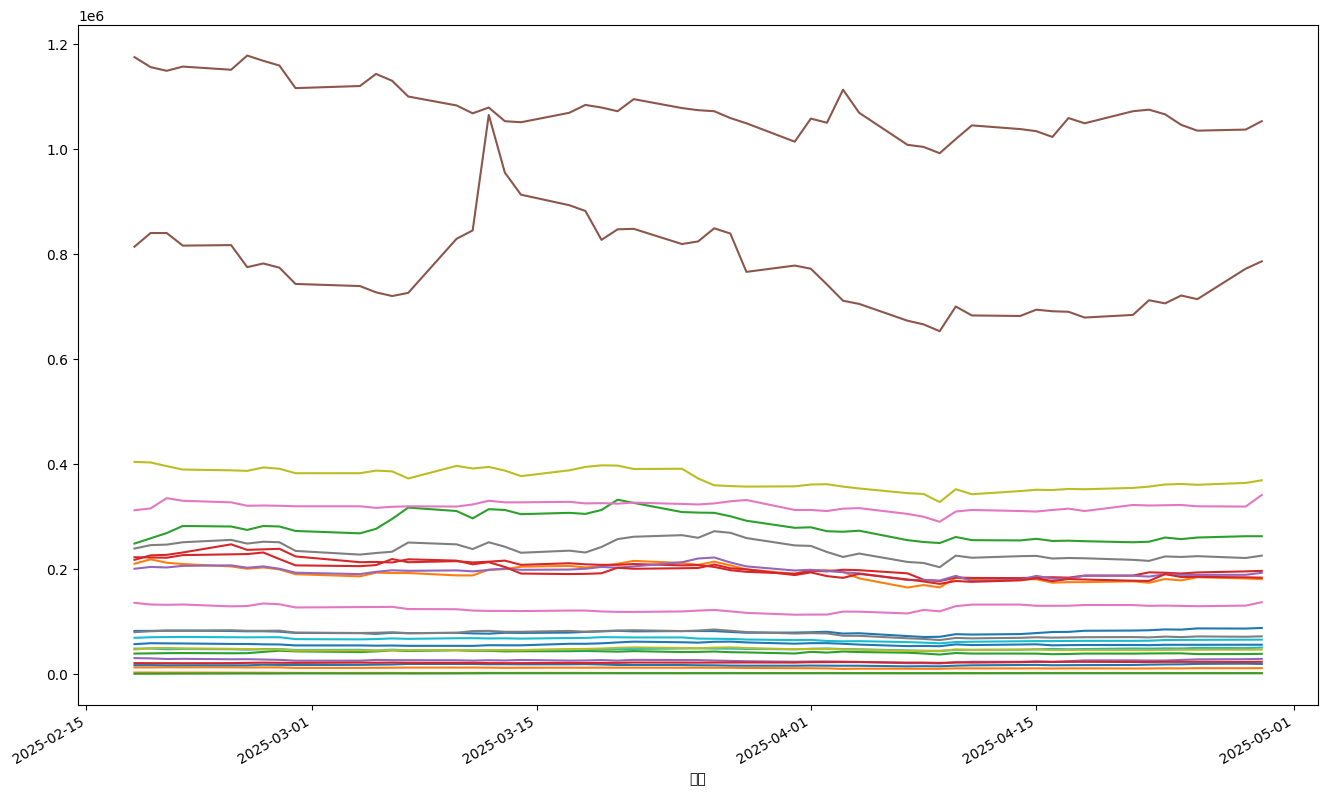

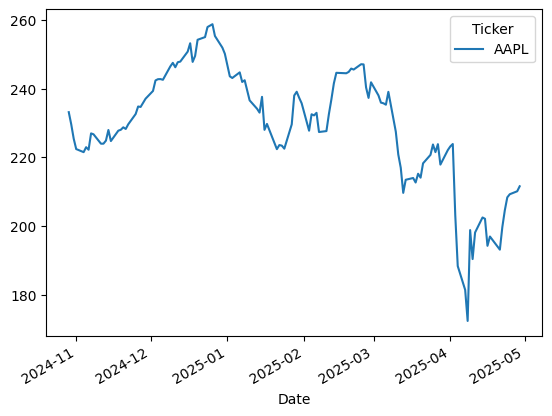

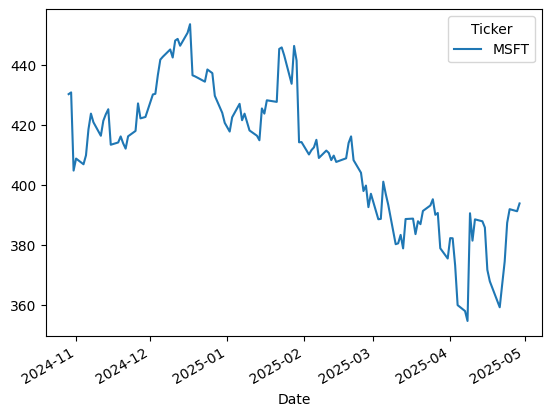

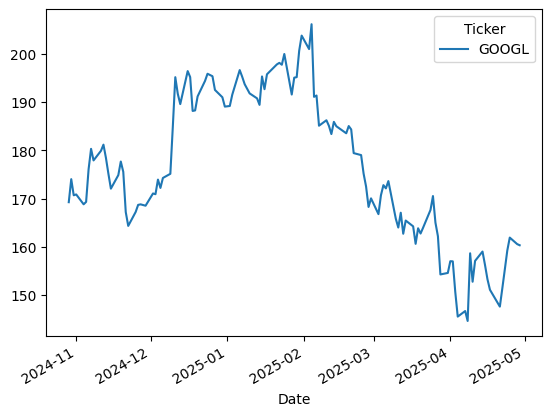

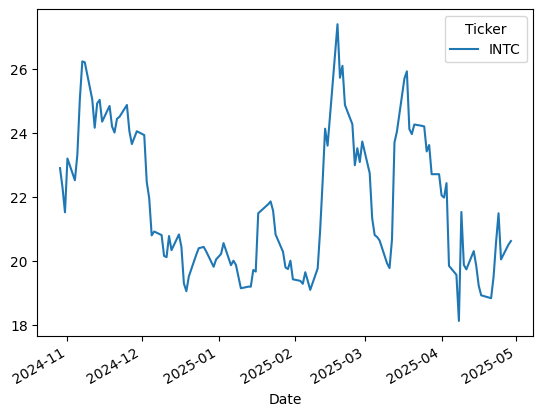

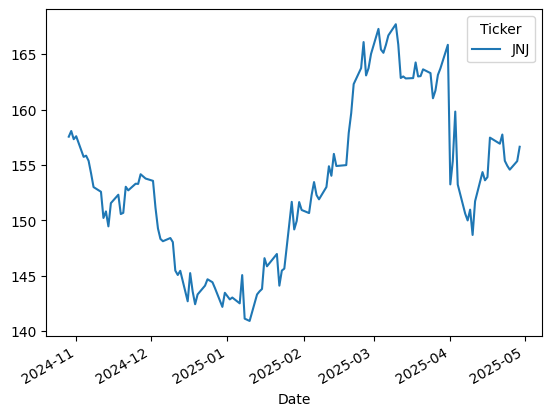

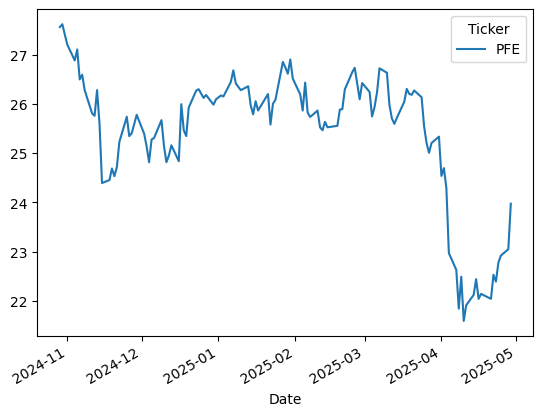

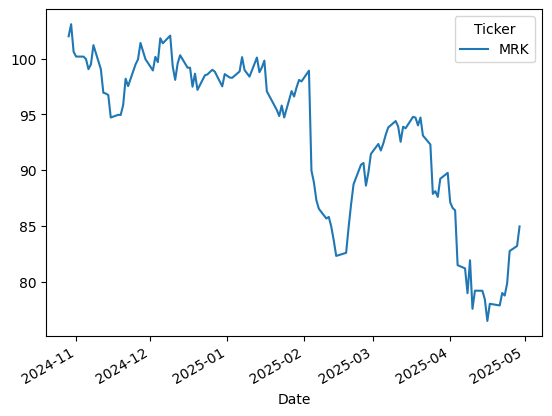

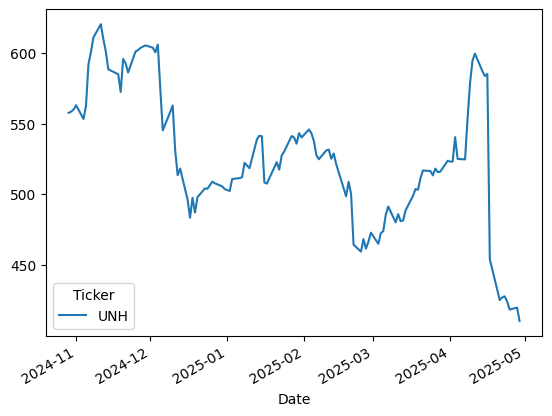

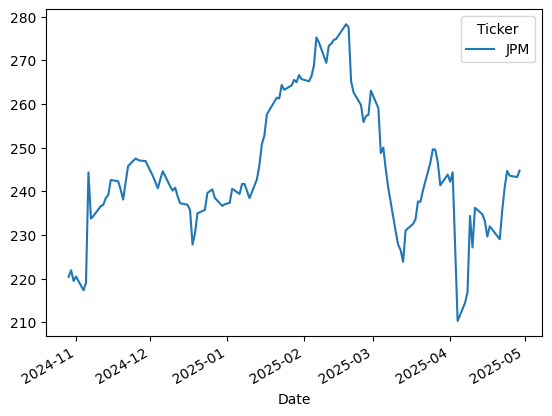

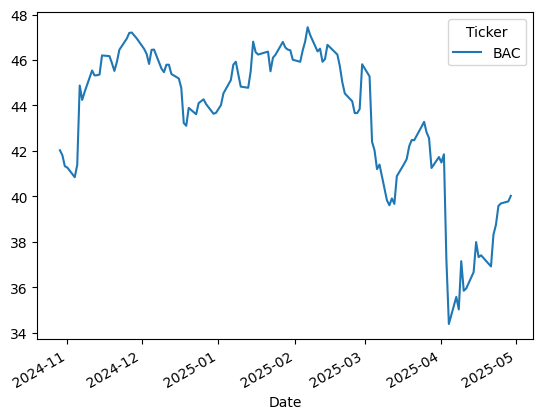

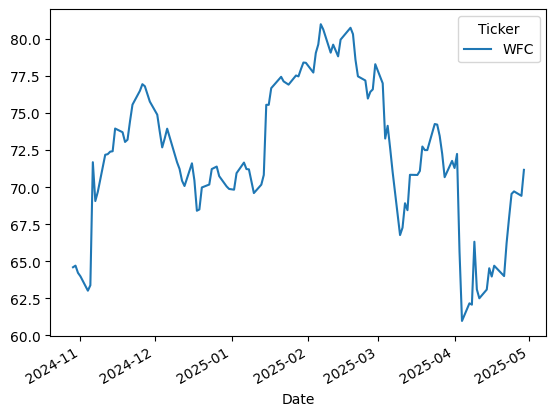

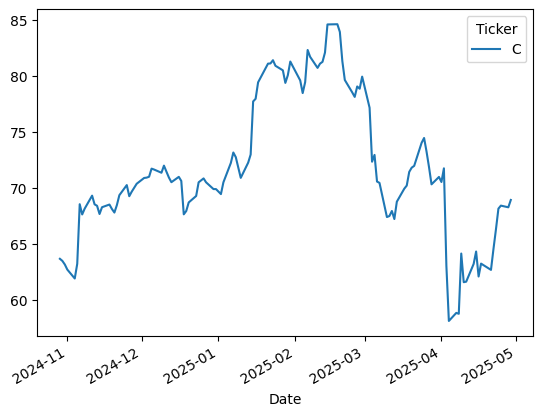

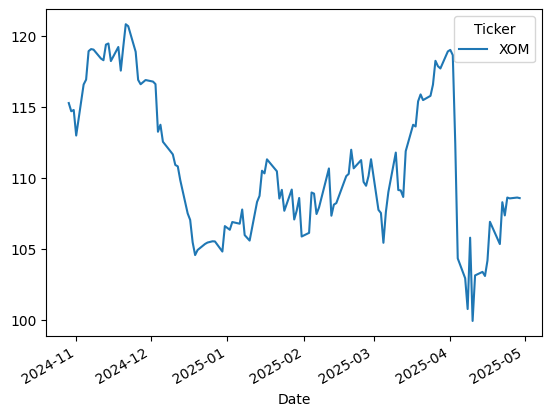

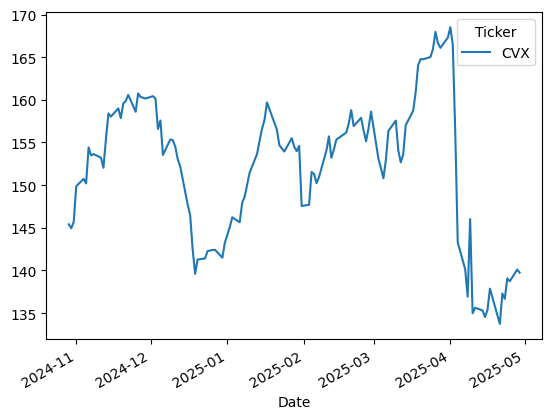

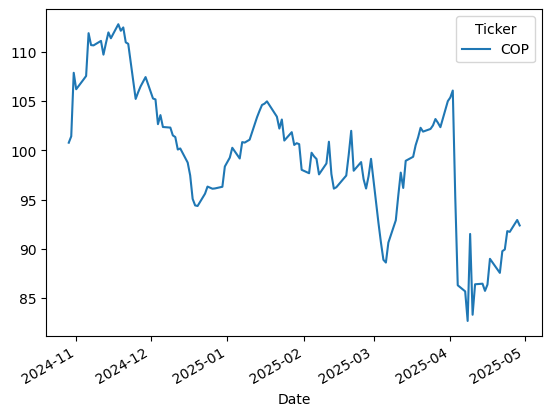

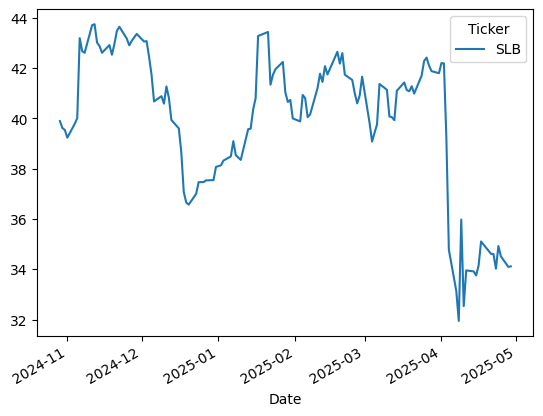

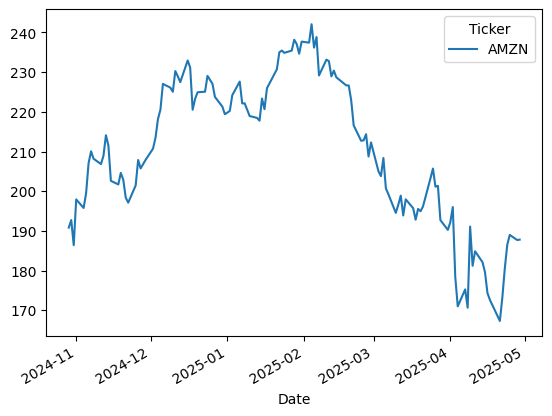

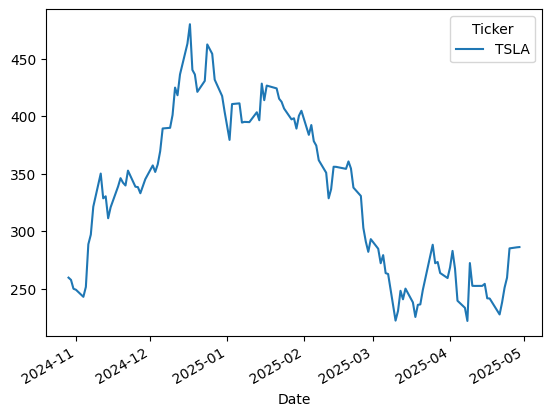

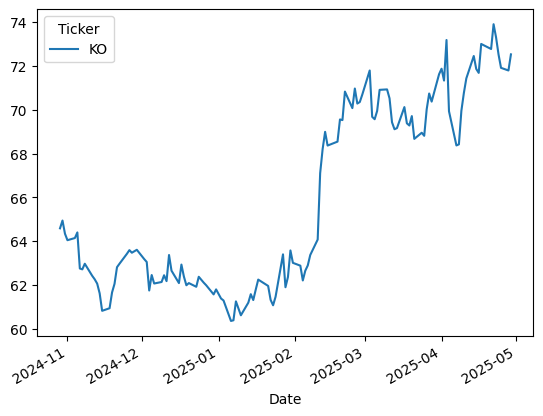

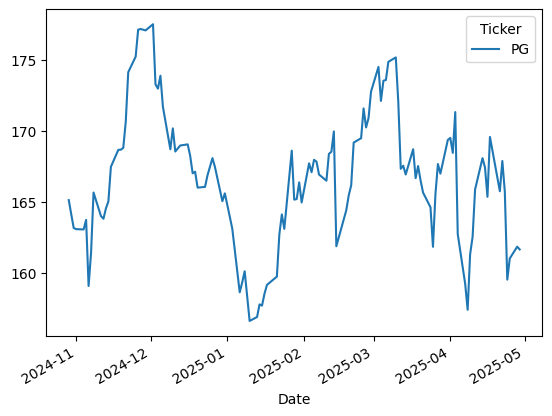

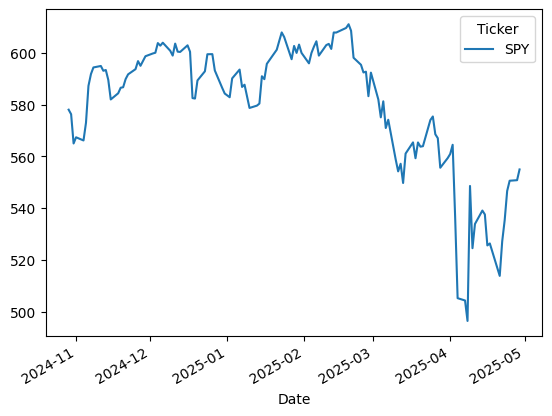

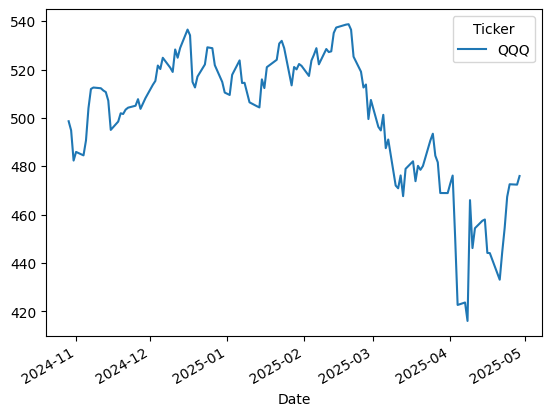

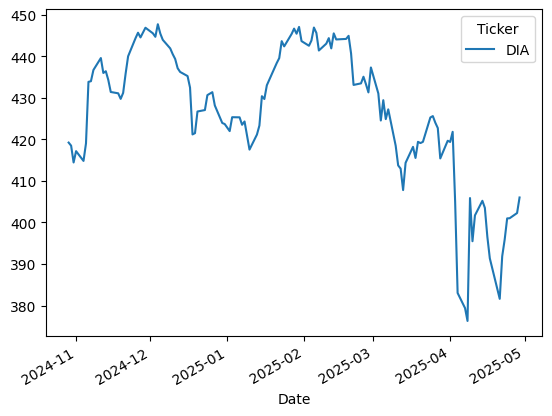

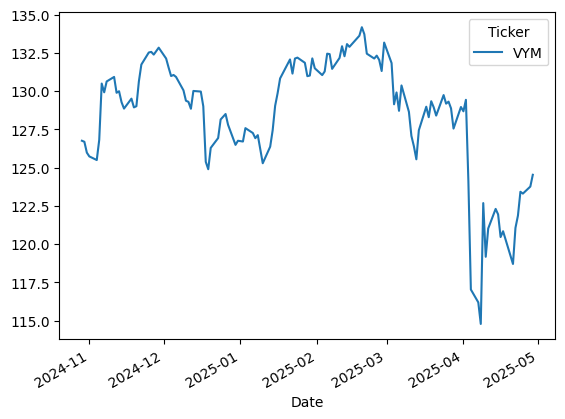

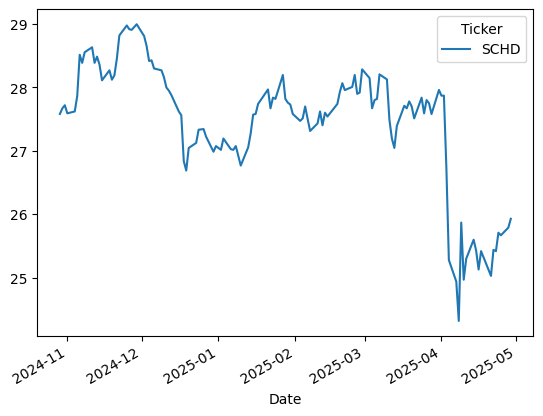

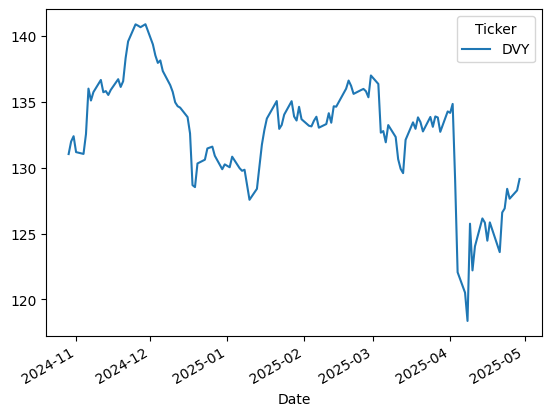

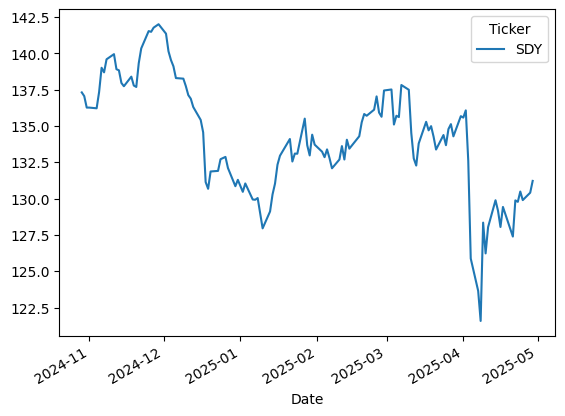

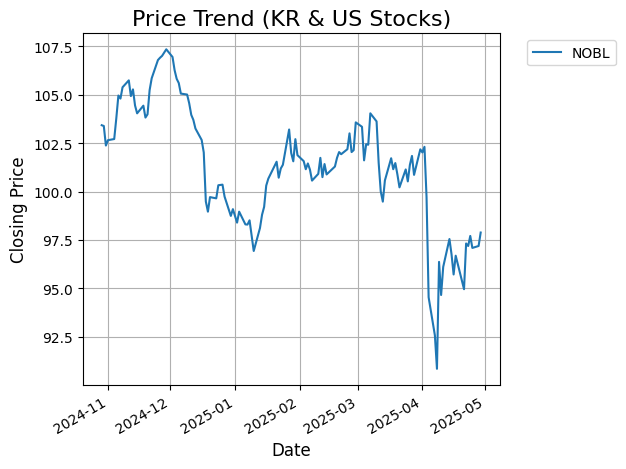

In [10]:
all_data = {}
plt.figure(figsize=(16,10))
# 국내
for sector, codes in domestic_sectors.items():
    for code in codes:
        df = fetch_domestic_stock(code)
        df['MA20'] = df['종가'].rolling(20).mean()
        df['MA60'] = df['종가'].rolling(60).mean()
        df['신호'] = np.where(df['MA20'] > df['MA60'], 1, 0)
        df['종가'].plot(label=f"KR-{sector}-{code}")
        all_data[f"KR-{code}"] = df
# 미국
for sector, tickers in us_sectors.items():
    for t in tickers:
        df = fetch_us_stock(t)
        df['MA20'] = df['종가'].rolling(20).mean()
        df['MA60'] = df['종가'].rolling(60).mean()
        df['신호'] = np.where(df['MA20'] > df['MA60'], 1, 0)
        df['종가'].plot(label=f"US-{sector}-{t}")
        all_data[f"US-{t}"] = df

plt.title('Price Trend (KR & US Stocks)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)

plt.grid(True) # 가독성을 위해 그리드 추가

# 범례 위치 설정
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() # 그래프 요소들이 겹치지 않도록 자동 조정
plt.show()


In [11]:
# 국내: Naver Finance에서 PER, PBR 크롤링
def fetch_domestic_fundamentals(code):
    url = 'https://finance.naver.com/item/main.nhn'
    soup = BeautifulSoup(requests.get(url, params={'code':code}, headers={'User-Agent':'Mozilla/5.0'}).text, 'lxml')
    table = soup.select_one('table.tb_type1')
    ths = [th.get_text() for th in table.select('th')]
    tds = [td.get_text().strip() for td in table.select('td')]
    data = dict(zip(ths, tds))
    return {
        'PER': float(data.get('PER', '0').replace('-', '0')),
        'PBR': float(data.get('PBR', '0').replace('-', '0'))
    }

# 미국: yfinance 이용
def fetch_us_fundamentals(ticker):
    info = yf.Ticker(ticker).info
    return {
        'PER': info.get('trailingPE', 0),
        'PBR': info.get('priceToBook', 0)
    }

fund_data = {}
for key in all_data:
    sym = key.split('-')[-1]
    if key.startswith('KR-'):
        try:
            fund_data[key] = fetch_domestic_fundamentals(sym)
        except:
            continue
    else:
        try:
            fund_data[key] = fetch_us_fundamentals(sym)
        except:
            continue
fund_df = pd.DataFrame(fund_data).T.dropna()
value_candidates = fund_df[(fund_df['PER']<15)&(fund_df['PBR']<1.5)].index.tolist()
print('가치투자 후보:', value_candidates)

가치투자 후보: ['KR-005930', 'KR-000660', 'KR-035720', 'KR-035420', 'KR-005380', 'KR-207940', 'KR-069620', 'KR-051910', 'KR-000810', 'KR-055550', 'KR-105560', 'KR-105630', 'KR-005490', 'KR-006400', 'KR-034020', 'KR-010130', 'KR-051900', 'KR-066570', 'KR-005935', 'KR-003550', 'KR-108380', 'KR-090710', 'KR-095660', 'US-INTC', 'US-BAC', 'US-WFC', 'US-C']


In [12]:
# 펀더멘털 정보 수집 (국내 PER/PBR, 미국 yfinance)
def fetch_domestic_fundamentals(code):
    url = 'https://finance.naver.com/item/main.nhn'
    soup = BeautifulSoup(requests.get(url, params={'code':code}, headers={'User-Agent':'Mozilla/5.0'}).text, 'lxml')
    tbl = soup.select_one('table.tb_type1')
    keys = [th.get_text() for th in tbl.select('th')]
    vals = [td.get_text().strip() for td in tbl.select('td')]
    d = dict(zip(keys, vals))
    return {'PER': float(d.get('PER','0').replace('-','0')), 'PBR': float(d.get('PBR','0').replace('-','0'))}

def fetch_us_fundamentals(ticker):
    info = yf.Ticker(ticker).info
    return {'PER': info.get('trailingPE',0), 'PBR': info.get('priceToBook',0)}

fund_data = {}
for key in all_data:
    sym = key.split('-')[-1]
    try:
        fund_data[key] = fetch_domestic_fundamentals(sym) if key.startswith('KR-') else fetch_us_fundamentals(sym)
    except:
        continue
fund_df = pd.DataFrame(fund_data).T.dropna()
value_candidates = fund_df[(fund_df['PER']<15) & (fund_df['PBR']<1.5)].index.tolist()

# 매수/매도 추천 레벨
value_recs = {}
for sym in value_candidates:
    df = all_data[sym]
    price = df['종가'].iloc[-1]
    per = fund_df.loc[sym, 'PER']
    pbr = fund_df.loc[sym, 'PBR']
    buy = round(price * 0.95, 2)
    sell = round(price * 1.1, 2)
    reason = f"저평가 PER {per:.1f}, PBR {pbr:.2f}"
    value_recs[sym] = {'현재가': round(price,2), '매수권장가': buy, '매도권장가': sell, '선정근거': reason}


In [13]:
value_recs = {}
for sym in value_candidates:
    df = all_data[sym]
    last_price = df['종가'].iloc[-1]
    per = fund_df.loc[sym,'PER']
    pbr = fund_df.loc[sym,'PBR']
    buy_price = last_price * 0.95
    sell_price = last_price * 1.1
    reason = f"PER {per:.1f}, PBR {pbr:.2f}로 저평가"
    value_recs[sym] = {'current_price': round(last_price,2), 'buy_below': round(buy_price,2), 'sell_above': round(sell_price,2), 'reason': reason}

print('가치투자 추천 레벨:')
for k,v in value_recs.items(): print(f"{k}: {v}")

가치투자 추천 레벨:
KR-005930: {'current_price': np.float64(56900.0), 'buy_below': np.float64(54055.0), 'sell_above': np.float64(62590.0), 'reason': 'PER 0.0, PBR 0.00로 저평가'}
KR-000660: {'current_price': np.float64(210000.0), 'buy_below': np.float64(199500.0), 'sell_above': np.float64(231000.0), 'reason': 'PER 0.0, PBR 0.00로 저평가'}
KR-035720: {'current_price': np.float64(38950.0), 'buy_below': np.float64(37002.5), 'sell_above': np.float64(42845.0), 'reason': 'PER 0.0, PBR 0.00로 저평가'}
KR-035420: {'current_price': np.float64(222500.0), 'buy_below': np.float64(211375.0), 'sell_above': np.float64(244750.0), 'reason': 'PER 0.0, PBR 0.00로 저평가'}
KR-005380: {'current_price': np.float64(200500.0), 'buy_below': np.float64(190475.0), 'sell_above': np.float64(220550.0), 'reason': 'PER 0.0, PBR 0.00로 저평가'}
KR-207940: {'current_price': np.float64(1175000.0), 'buy_below': np.float64(1116250.0), 'sell_above': np.float64(1292500.0), 'reason': 'PER 0.0, PBR 0.00로 저평가'}
KR-069620: {'current_price': np.float64(135

# 2단계 : 네이버 뉴스 헤드라인 크롤링 및 중복 제거, 감성 분류

In [14]:
!pip install selenium webdriver-manager

In [15]:
import time
import pandas as pd # 최종 결과 확인 등을 위해 유지 (선택 사항)
from urllib.parse import quote # URL 인코딩을 위해 requests.utils 대신 사용
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, WebDriverException, NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager
from urllib.parse import quote_plus


# --- WebDriver 설정 ---
options = Options()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
options.add_argument('--disable-gpu')
# 사용자 에이전트 설정 (봇 탐지 방지 도움)
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36')

# --- WebDriver 초기화 ---
driver = webdriver.Chrome(options=options)
def fetch_naver_news(query, limit=20):
    url = f"https://search.naver.com/search.naver?where=news&query={quote_plus(query)}"
    driver.get(url)
    time.sleep(2)
    # 스크롤 로딩
    for _ in range(3):
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        time.sleep(1)
    results = []
    # 헤드라인 텍스트 선택자
    spans = driver.find_elements(By.CSS_SELECTOR, 'span.sds-comps-text-type-headline1')
    for span in spans[:limit]:
        title = span.text.strip()
        link = span.find_element(By.XPATH, './ancestor::a').get_attribute('href')
        results.append({'title': title, 'link': link})
    print(f"Naver 뉴스: {len(results)}건 수집")
    return pd.DataFrame(results)


# Selenium 버전 함수 호출
domestic_df = fetch_naver_news('주가전망')
domestic_news = domestic_df['title'].tolist()
print(domestic_news)

Naver 뉴스: 20건 수집
['[단독] “주가 3배 뛴 지금이 적기”…산은, K조선 호황에 한화오션 지...', '신한證 "SKT 유심 교체, 최대 2000억 부담…주가 회복 전망"', '한화오션, 산은 지분매각에 고점·오버행 우려…주가 12% 급락(종합)', '산은 “생큐 ! 트럼프”… 한화오션 주가 급등에 지분매각 착수', '"모건스탠리 경고"…SK하이닉스 주가 괜찮을까', "'화웨이 직격탄'에 엔비디아 주가 폭락…이유는?", '[특징주] 삼양식품, 호실적 전망에 상승세…황제주 복귀 코 앞', '"면세점 바닥" 의견에 호텔신라 주가 급등…위기 돌파 가능할까 [종목+...', "iM금융지주, 1분기 호실적 발표에 주가도 '훨훨'", "LG생활건강 주가 '껑충'... 실적 부진에도 왜 뛰나?", 'SK하이닉스, 단기 호재로 주가 반등 전망-키움', 'DS투자 "CJ제일제당, 식품 부진·바이오 기저 부담…목표주가↓"', '뱃고동 소리 커지지만…조선3사 주가 너무 올랐나 ‘공매도’↑', '“SK텔레콤, 유심 해킹 사태 장기화 우려에 주가 급락”', '美연준 금융안정보고서 "최근 증시 조정에도 주가 여전히 높아"', '한미약품, 1Q 영업이익 25% 감소 전망…"자회사 부진 지속"', '“드디어 박스권 탈출하나”…옛 ‘황제주’ LG생건 목표가 상향에 주가...', '美 애리조나, 비트코인 공식 보유 첫 주가 될까', '[특징주] 한화오션 주가 7만원대로 급락, 산은 블록딜 악재', '[체크!코스피] 롯데관광개발, 1분기 호실적 전망… 주가 한 달 새 22%↑']


['Stock Market Today: S&P 500, Dow Rise; Earnings in Focus — Live Updates - WSJ', "Trump’s First 100 Days Were Worst for Stocks Since Nixon. What History Says Happens Next. - Barron's", '10% Returns in the Stock Market - A Wealth of Common Sense', 'Ranked: Top Countries by Stock Market Ownership - Visual Capitalist', 'The Stock Market May Rise or Fall Sharply This Week Based on Key Reports From Amazon, Apple, Meta Platforms, and Microsoft - The Motley Fool', "Charles Payne analyzes the stock market's major rebound - Fox Business", '5 things to know before the stock market opens Tuesday - MSN', 'New York City’s Multifamily Is a Port Amid the Stock Market Storm - Commercial Observer', "Jim Cramer's top 10 things to watch in the stock market Tuesday - CNBC", 'Opinion: Americans are betting too much of their retirement on the U.S. stock market. They should be doing this instead. - MarketWatch', 'S&P 500 ticks higher as investors await trade deal progress: Live updates - CNBC', "Stock Marke

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cpu


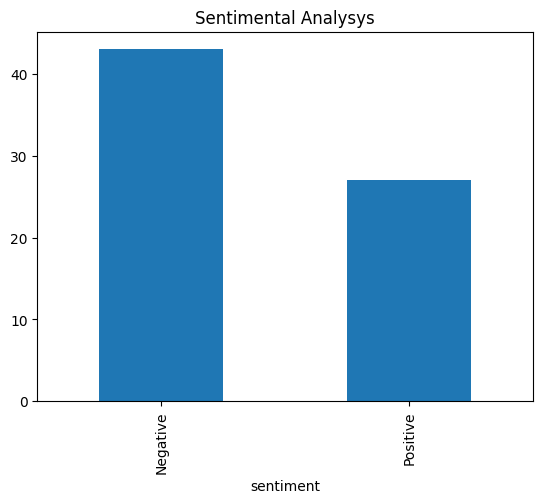

In [16]:
# 글로벌 뉴스
feed = feedparser.parse('https://news.google.com/rss/search?q=stock+market&hl=en-US&gl=US&ceid=US:en')
global_news = [e.title for e in feed.entries][:50]
print(global_news)

texts = domestic_news + global_news
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')
res = classifier(texts)
sent_df = pd.DataFrame({'text':texts,'label':[r['label'] for r in res],'score':[r['score'] for r in res]})
sent_df['sentiment'] = sent_df['label'].apply(lambda x:'Positive' if int(x[0])>=4 else 'Negative')
summary_sent = sent_df['sentiment'].value_counts()
summary_sent.plot(kind='bar')
plt.title('Sentimental Analysys')
plt.show()

#3단계 : Fear & Greed 지수 크롤링


In [17]:
def fetch_fear_greed():
    url = "https://api.alternative.me/fng/"
    resp = requests.get(url, params={"limit":1, "format":"json"}, timeout=5)
    resp.raise_for_status()
    data = resp.json()
    value = data['data'][0]['value']
    return int(value)

fear_greed_index = fetch_fear_greed()
fng_value = fear_greed_index
print(f"Fear & Greed 지수: {fear_greed_index}")

Fear & Greed 지수: 60


F&G API 호출 시도 1/3
F&G 데이터 캐시에 저장 완료
F&G 데이터 수신: 30건
Saved fear_greed_trend.png
차트 저장 완료: fear_greed_trend.png
현재 시장 심리 단계: Neutral (F&G 지수: 60)


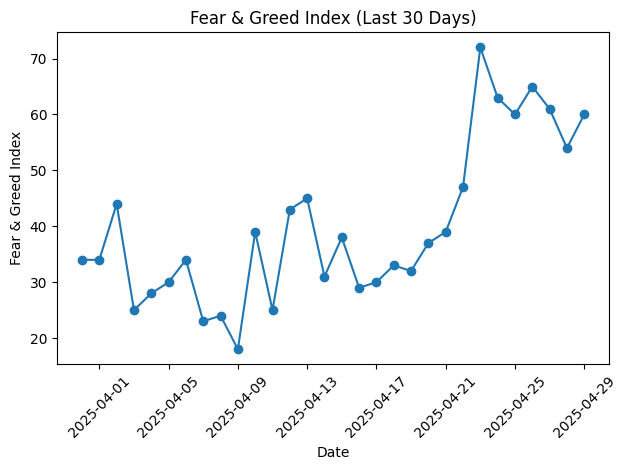

In [18]:
import json
cache_file = 'fg_history_cache.json'
def fetch_fear_greed_history(days=30, retries=3, backoff=2):
    url = f'https://api.alternative.me/fng/?limit={days}&format=json'
    data = None
    for attempt in range(1, retries+1):
        try:
            print(f'F&G API 호출 시도 {attempt}/{retries}')
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            raw = response.json().get('data', [])
            if raw:
                data = raw
                with open(cache_file, 'w', encoding='utf-8') as cf:
                    json.dump({'timestamp': time.time(), 'data': data}, cf)
                print('F&G 데이터 캐시에 저장 완료')
                break
        except Exception as e:
            print(f'F&G API 호출 실패: {e}')
            if attempt < retries:
                time.sleep(backoff)
    if data is None and os.path.exists(cache_file):
        print('캐시된 F&G 데이터 로드')
        with open(cache_file, 'r', encoding='utf-8') as cf:
            cached = json.load(cf)
            data = cached.get('data', [])
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['timestamp'].astype(int), unit='s')
    df['value'] = df['value'].astype(int)
    return df.sort_values('time')

fg_history = fetch_fear_greed_history(30)
print(f"F&G 데이터 수신: {len(fg_history)}건")

# 차트 생성 및 시각화
plt.figure()
plt.plot(fg_history['time'], fg_history['value'], marker='o')
plt.title('Fear & Greed Index (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Fear & Greed Index')
plt.xticks(rotation=45)
plt.tight_layout()
fear_greed_chart = 'fear_greed_trend.png'
plt.savefig(fear_greed_chart)
print(f'Saved {fear_greed_chart}')
print(f"차트 저장 완료: {fear_greed_chart}")

# 현재 시장 심리 단계 분석
current_fg = fg_history['value'].iloc[-1]
if current_fg <= 20:
    stage = 'Extreme Fear'
elif current_fg <= 40:
    stage = 'Fear'
elif current_fg <= 60:
    stage = 'Neutral'
elif current_fg <= 80:
    stage = 'Greed'
else:
    stage = 'Extreme Greed'
print(f"현재 시장 심리 단계: {stage} (F&G 지수: {current_fg})")

#4단계: 수집된 데이터 기반 GPT API 호출로 시장 상황 요약 및 종목 추천

In [19]:
today=datetime.date.today()
report={
    'quant_buy_signals':[k for k,v in all_data.items() if v['신호'].iloc[-1]==1],
    'value_recommendations':value_recs,
    'news_sentiment':summary_sent.to_dict(),
    'fear_greed':fng_value
}
prompt=f"""
Daily Investment Report - {today}

1. Quant Signals:
{report['quant_buy_signals']}

2. Value Recommendations:
{report['value_recommendations']}

3. News Sentiment Distribution:
{report['news_sentiment']}

4. Fear & Greed Index: {report['fear_greed']}

Please analyze and provide:
- Market summary
- Justification for value recommendations
- Suggested entry (buy_below) and exit (sell_above) prices
- Sector-specific top 5 picks
"""
response = openai.chat.completions.create(
    model='gpt-4o-mini',
    messages=[{'role':'user','content':prompt}],

)
advice=response.choices[0].message.content
print(advice)

### Market Summary
As of April 29, 2025, the overall market sentiment leans towards a bullish outlook, reflecting a Fear & Greed Index of 60, which indicates that investors are leaning more towards greed and optimism. However, the news sentiment is mixed, with a distribution of 43 negative to 27 positive sentiments, suggesting underlying caution in the market. The quant signals indicate potential opportunities in UnitedHealth (US-UNH) and Coca-Cola (US-KO), both well-established companies in their respective sectors. 

### Justification for Value Recommendations
The value recommendations provided reflect stocks deemed undervalued with a price-to-earnings ratio (PER) of 0.0 and a price-to-book ratio (PBR) of 0.00. This implies that these stocks may be trading significantly below their intrinsic value, suggesting an opportunity for potential upside. The rationale for investing is bolstered by their historical performance, market position, and the broader economic backdrop.

### Suggested

In [20]:
translation_prompt = f"위의 영어 투자 조언 결과를 내용을 누락 없이, 투자전문가의 역할로서 한국어로 번역해주세요 (markdown 문법을 활용해주세요.):\n\n{advice}"
response = openai.chat.completions.create(
    model='gpt-4o-mini',
    messages=[{'role':'user','content':translation_prompt}],
).choices[0].message.content

translation_advise = response.strip()
print(translation_advise)

### 시장 요약
2025년 4월 29일 기준으로 전체 시장 심리는 강세 전망으로 기울어져 있으며, 공포 및 탐욕 지수는 60으로 나타나 투자자들이 탐욕과 낙관적으로 접근하고 있음을 시사합니다. 하지만 뉴스 심리는 혼합되어 있으며, 부정적인 감정 43건에 비해 긍정적인 감정이 27건으로 배분되어 있어 시장에 대한 내재된 조심스러움이 존재합니다. 정량적 신호는 각각의 섹터에서 잘 알려진 회사인 유나이티드헬스(US-UNH)와 코카콜라(US-KO)에서 잠재적인 기회를 나타내고 있습니다.

### 가치 추천의 근거
제공된 가치 추천은 주가수익비율(PER) 0.0 및 주가장부비율(PBR) 0.00를 가진 저평가된 주식을 반영합니다. 이는 해당 주식들이 본질 가치에 비해 상당히 낮은 가격에서 거래되고 있을 수 있음을 시사하며, 잠재적인 상승 기회를 나타냅니다. 투자 근거는 이들의 역사적 성과, 시장 위치 및 광범위한 경제적 배경에 의해 강화됩니다.

### 권장 매수(구매 가격 이하) 및 매도(판매 가격 이상) 가격
각 주식에 대한 권장 매수 및 매도 가격은 현재 시장 가격과 해당 주식의 가치 평가에 기반하여 설정되었습니다:

#### 한국 주식:
1. **삼성전자 (KR-005930)**
   - 매수 가격 이하: **54,055**
   - 매도 가격 이상: **62,590**
   
2. **SK 하이닉스 (KR-000660)**
   - 매수 가격 이하: **199,500**
   - 매도 가격 이상: **231,000**
   
3. **카카오 (KR-035720)**
   - 매수 가격 이하: **37,002.5**
   - 매도 가격 이상: **42,845**
   
4. **네이버 주식회사 (KR-035420)**
   - 매수 가격 이하: **211,375**
   - 매도 가격 이상: **244,750**

5. **LG화학 (KR-051910)**
   - 매수 가격 이하: **227,050**
   - 매도 가격 이상: **262,900**

###

#5단계: Slack으로 추천 결과 전송

In [21]:
slack_client.chat_postMessage(channel=SLACK_CHANNEL, text=translation_advise)
print("Slack에 추천 결과를 전송했습니다.")

Slack에 추천 결과를 전송했습니다.


### 시장 요약
2025년 4월 29일 기준으로 전체 시장 심리는 강세 전망으로 기울어져 있으며, 공포 및 탐욕 지수는 60으로 나타나 투자자들이 탐욕과 낙관적으로 접근하고 있음을 시사합니다. 하지만 뉴스 심리는 혼합되어 있으며, 부정적인 감정 43건에 비해 긍정적인 감정이 27건으로 배분되어 있어 시장에 대한 내재된 조심스러움이 존재합니다. 정량적 신호는 각각의 섹터에서 잘 알려진 회사인 유나이티드헬스(US-UNH)와 코카콜라(US-KO)에서 잠재적인 기회를 나타내고 있습니다.
### 가치 추천의 근거
제공된 가치 추천은 주가수익비율(PER) 0.0 및 주가장부비율(PBR) 0.00를 가진 저평가된 주식을 반영합니다. 이는 해당 주식들이 본질 가치에 비해 상당히 낮은 가격에서 거래되고 있을 수 있음을 시사하며, 잠재적인 상승 기회를 나타냅니다. 투자 근거는 이들의 역사적 성과, 시장 위치 및 광범위한 경제적 배경에 의해 강화됩니다.
### 권장 매수(구매 가격 이하) 및 매도(판매 가격 이상) 가격
각 주식에 대한 권장 매수 및 매도 가격은 현재 시장 가격과 해당 주식의 가치 평가에 기반하여 설정되었습니다:
#### 한국 주식:
1. **삼성전자 (KR-005930)**
   - 매수 가격 이하: **54,055**
   - 매도 가격 이상: **62,590**
2. **SK 하이닉스 (KR-000660)**
   - 매수 가격 이하: **199,500**
   - 매도 가격 이상: **231,000**
3. **카카오 (KR-035720)**
   - 매수 가격 이하: **37,002.5**
   - 매도 가격 이상: **42,845**
4. **네이버 주식회사 (KR-035420)**
   - 매수 가격 이하: **211,375**
   - 매도 가격 이상: **244,750**
5. **LG화학 (KR-051910)**
   - 매수 가격 이하: **227,050**
   - 매도 가격 이상: **262,900**
#### 미국 주식:
1. **인텔 코퍼레이션 (US-INTC)**
   - 매수 가격 이하: **19.59**
   - 매도 가격 이상: **22.69**
2. **뱅크 오브 아메리카 (US-BAC)**
   - 매수 가격 이하: **38.02**
   - 매도 가격 이상: **44.03**
3. **웰스 파고 & 코 (US-WFC)**
   - 매수 가격 이하: **67.63**
   - 매도 가격 이상: **78.30**
4. **시티그룹 주식회사 (US-C)**
   - 매수 가격 이하: **65.49**
   - 매도 가격 이상: **75.83**
### 섹터별 추천 Top 5
추천에 기반하여 다양한 섹터에서의 Top 5 주식을 선정하였습니다. 이는 한국 및 미국 시장을 포함합니다:
1. **기술**
   - **삼성전자 (KR-005930)**
   - **인텔 코퍼레이션 (US-INTC)**
2. **금융**
   - **뱅크 오브 아메리카 (US-BAC)**
   - **웰스 파고 & 코 (US-WFC)**
3. **소비재**
   - **카카오 (KR-035720)**
4. **필수 소비재**
   - **코카콜라 (US-KO)** - 가치 추천에는 포함되어 있지 않으나 정량 신호에 기반하여 중요한 주식으로 포함됨.
5. **재료**
   - **LG화학 (KR-051910)**
이 주식들은 가치 평가 지표, 성장 잠재력 및 기본 경제 지표를 바탕으로 하여 현재 시장 조건에서 투자가 적합한 것으로 추천됩니다.






